# OLA - Ensemble Learning

## 1. Define Problem Statement
The Problem is to predict **driver churn** for Ola. Churn refer to the likelihood that a driver will leave the company. Factor like age, income, business value, and quarterly rating can contribute to driver attrition. 
Given driver attributes such as age, income, education level, total business value, tenure, and performance ratings, predict whether a driver will leave Ola.
By identifying at-risk drivers, the company can take proactive measures to reduce attrition and improve retention.

In [1]:
# Importing the necessary libraries
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 2. Exploratory Data Analysis (EDA)


In [2]:
# Data overview
df = pd.read_csv('../Data/ola_driver_scaler.csv')
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [3]:
# initial check 

# shape of the data
print("Shape of the data : ", df.shape)

# Data types of each column
print(df.dtypes)

# Checking for missing values
print(df.isnull().sum())



Shape of the data :  (19104, 14)
Unnamed: 0                int64
MMM-YY                   object
Driver_ID                 int64
Age                     float64
Gender                  float64
City                     object
Education_Level           int64
Income                    int64
Dateofjoining            object
LastWorkingDate          object
Joining Designation       int64
Grade                     int64
Total Business Value      int64
Quarterly Rating          int64
dtype: object
Unnamed: 0                  0
MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64


### Initial Observations:
1. **Shape of Data:**
   1. Rows: 19, 104
   2. Columns: 14
2. **Data Types:** The column types are mostly correct. However:
   *  MMM-YY, Dateofjoining, and LastWorkingDate: These should ideally be in `datetime` format
3. **Unnamed: 0:** This column appears to be an index that was unintentionally red in. It's not necessary, so it can be dropped.
4. **Missing Values:** 
   1. Age : 61 missing values
   2. Gender : 52 missing values
   3. LastWorkingDate : 17,488 missing values 

In [5]:
# remove the unnecessary columns
df = df.drop(columns=['Unnamed: 0'])

In [7]:
# Convert specific columns to category type
categorical_cols = ['Gender', 'City', 'Education_Level', 'Joining Designation','Grade'] 
df[categorical_cols] = df[categorical_cols].astype('category')

In [8]:
# statistical summary of numerical columns
df.describe()

,Driver_ID,Age,Income,Total Business Value,Quarterly Rating
count,19104.000000,19043.000000,19104.000000,1.910400e+04,19104.000000
mean,1415.591133,34.668435,65652.025126,5.716621e+05,2.008899
std,810.705321,6.257912,30914.515344,1.128312e+06,1.009832
min,1.000000,21.000000,10747.000000,-6.000000e+06,1.000000
25%,710.000000,30.000000,42383.000000,0.000000e+00,1.000000
50%,1417.000000,34.000000,60087.000000,2.500000e+05,2.000000
75%,2137.000000,39.000000,83969.000000,6.997000e+05,3.000000
max,2788.000000,58.000000,188418.000000,3.374772e+07,4.000000


In [9]:
# Convert date columns to datetime format
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'], format='%d/%m/%y')
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'], format='%d/%m/%y')
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'], format='%d/%m/%y')


In [10]:
# Handling missing values for Age and Gender by imputing median 
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

# Replace missing 'LastWorkingDate' with a placeholder for 'active' drivers
df['LastWorkingDate'].fillna('Still Working', inplace=True)

In [12]:
# let's check the data overview now after all the missing value handling and type casting
print('After removing the unnecessary columns :\n', df.head())
print('After change the date columns to proper datetime type :\n',df.dtypes)
print('After filling the missing values of the data with proper values :\n',df.isnull().sum())

After removing the unnecessary columns :
       MMM-YY  Driver_ID   Age Gender City Education_Level  Income  \
0 2019-01-01          1  28.0    0.0  C23               2   57387   
1 2019-01-02          1  28.0    0.0  C23               2   57387   
2 2019-01-03          1  28.0    0.0  C23               2   57387   
3 2020-01-11          2  31.0    0.0   C7               2   67016   
4 2020-01-12          2  31.0    0.0   C7               2   67016   

  Dateofjoining      LastWorkingDate Joining Designation Grade  \
0    2018-12-24        Still Working                   1     1   
1    2018-12-24        Still Working                   1     1   
2    2018-12-24  2019-11-03 00:00:00                   1     1   
3    2020-06-11        Still Working                   2     2   
4    2020-06-11        Still Working                   2     2   

   Total Business Value  Quarterly Rating  
0               2381060                 2  
1               -665480                 2  
2             

### Univariate Analysis


* **Continuos Variables**:
    * Age: Examine the distribution and summary statistics
    * Income: Understand income distribution
    * Total Business value: Explore its distribution, particularly since it includes both negative and positive values 

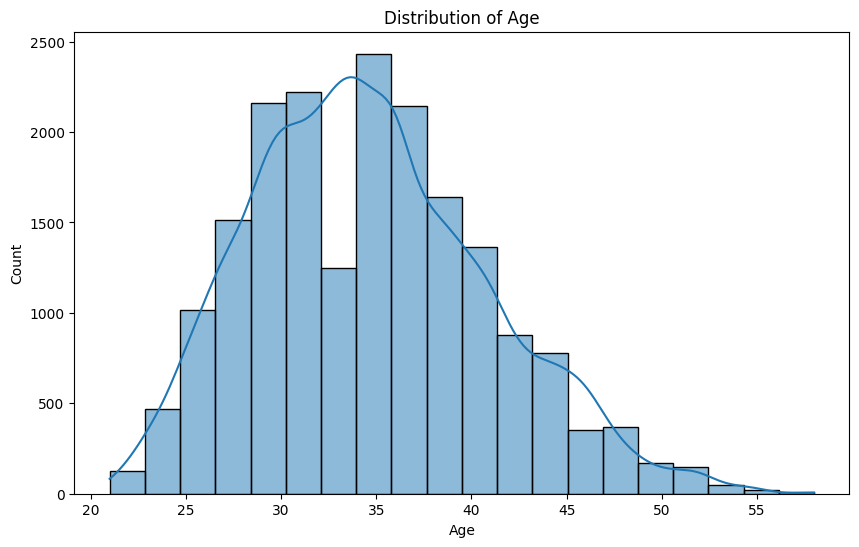

In [13]:
# distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.show()

#### Observations:
* The age distribution appears normal is insightful. A normal distribution typically means the data symmetrically distributed around the mean
* The mode being 35 years indicates that the age is most common among all drivers
* The age range from 20 to 55(and occasionally up to 60) shows a reasonable diversity in age among drivers.

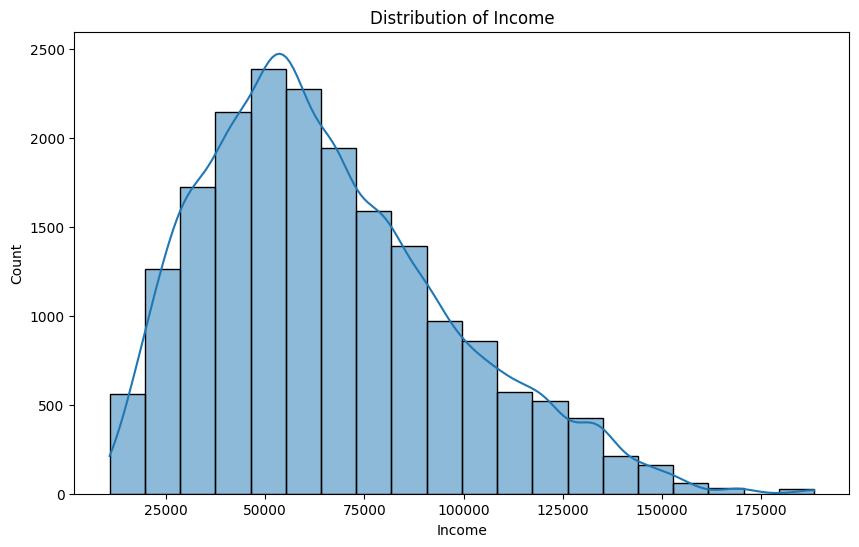

In [14]:
# Distribution of Income
plt.figure(figsize=(10, 6))
sns.histplot(df['Income'], bins=20, kde=True)
plt.title('Distribution of Income')
plt.show()

#### Observations:
* The positive skewness(right-skewed) indicates that there some high income drivers that are pulling the mean to the right. The majority of drivers earn less than high-income outliers
* The fact that most earnings are around 50,000 suggests this is the typical income for the drivers
* The range from 20,000 to 180,000 with some outliers beyond 175,000 suggests a wide variation in income. The outliers are significantly higher than the majority, which could impact mean income

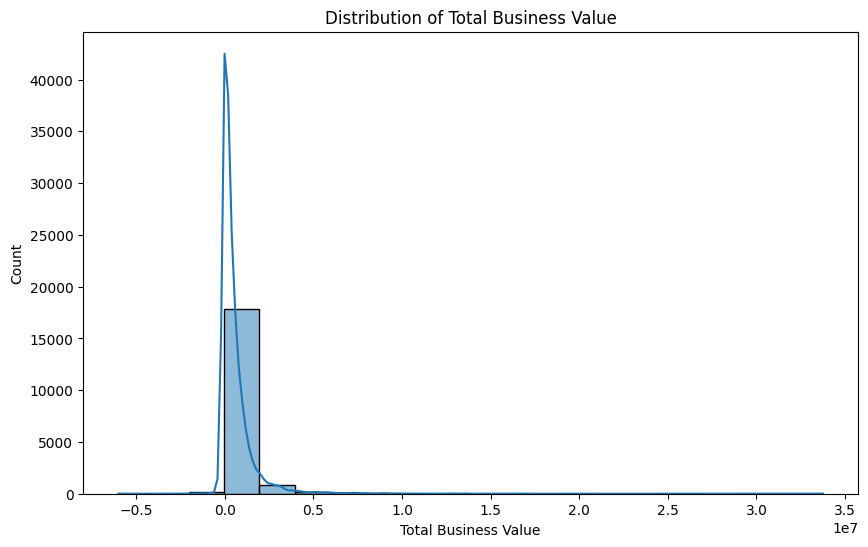

In [15]:
# Distribution of Total Value
plt.figure(figsize=(10, 6))
sns.histplot(df['Total Business Value'], bins=20, kde=True)
plt.title('Distribution of Total Business Value')
plt.show()

#### Observations:
* The long spike at 0.0 suggests that a significant portion of the business value data is at zero, possibly indicating with no business value or refunds. The sudden drop at 0.5 might indicates a cutoff or a data error
* The range from -0.5 to 0.5 with peak at 0.0 and high count at 0.0 suggest that many drivers have zero or very low total business value.


* **Categorical Variables:**
  * Gender : Count plot for gender distribution
  * City : Count plot city Distribution
  * Education Level: Count plot for education levels
  * Quarterly Ratings : Count plot for rating distribution

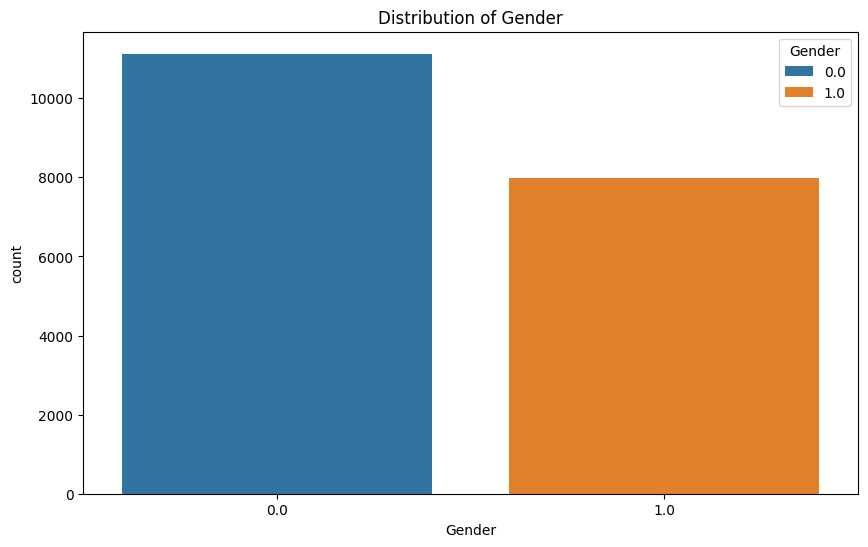

In [20]:
# Count plot for Gender
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', data=df, hue='Gender')
plt.title('Distribution of Gender')
plt.show()

#### Observations:
**Gender:**
* 0.0(Male) : 11,074 
* 1.0(Female) : 7,978
  
* There is a noticeable difference between the number of male and female drivers, with male drivers making up a higher percentage(~58%) compared to female drivers(~42%).

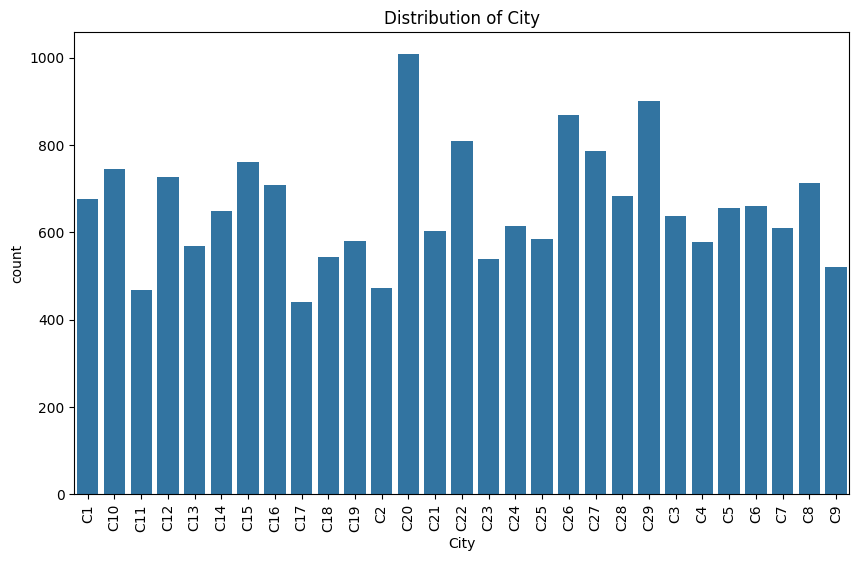

In [17]:
# count plot fot city
plt.figure(figsize=(10, 6))
sns.countplot(x='City', data=df)
plt.title('Distribution of City')
plt.xticks(rotation=90)
plt.show()

#### Observations
**City**:
* This column has many unique values (city codes). Some of the most frequent cities included: 
    * C20: 1,008 drivers
    * C29: 900 drivers
    * C26: 869 drivers
* The distribution of drivers across cities seems somewhat uneven. For instance, the number of drivers varies from 1,008 in city C20 to  440 in city C17
* The variation could suggests that certain cities are more favorable for driver retention, while others may have challenges like higher churn.
  

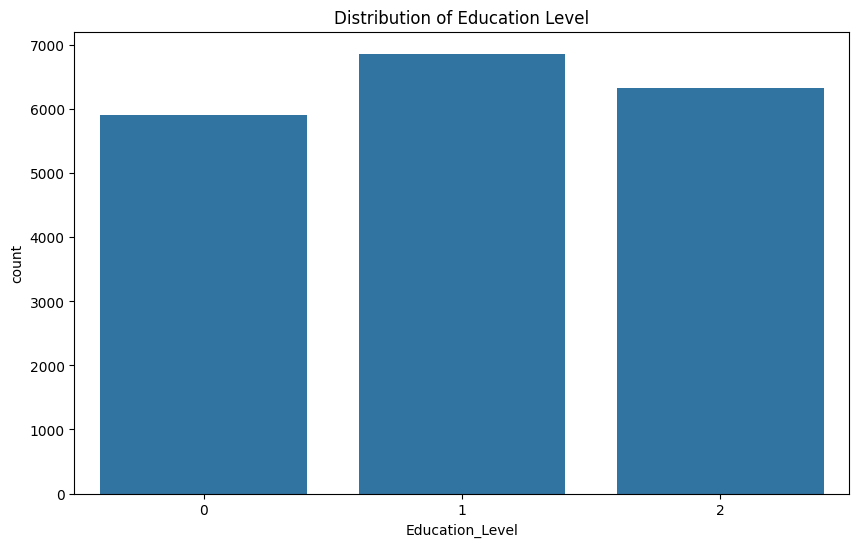

In [18]:
# Count plot for Education Level
plt.figure(figsize=(10, 6))
sns.countplot(x='Education_Level', data=df)
plt.title('Distribution of Education Level')
plt.show()

#### Observations:
**Education Level:**
* 1(12+) : 6,864 drivers
* 2(Graduate) : 6,327 drivers
* 0(10+) : 869 drivers

1. The distribution is fairly balanced across education level, though slightly more drivers have 12+ education than other levels.
2. Graduate-level drivers(6,327) could be analyzed separately to see if higher education correlates wth better earnings, ratings, or tenure with Ola.

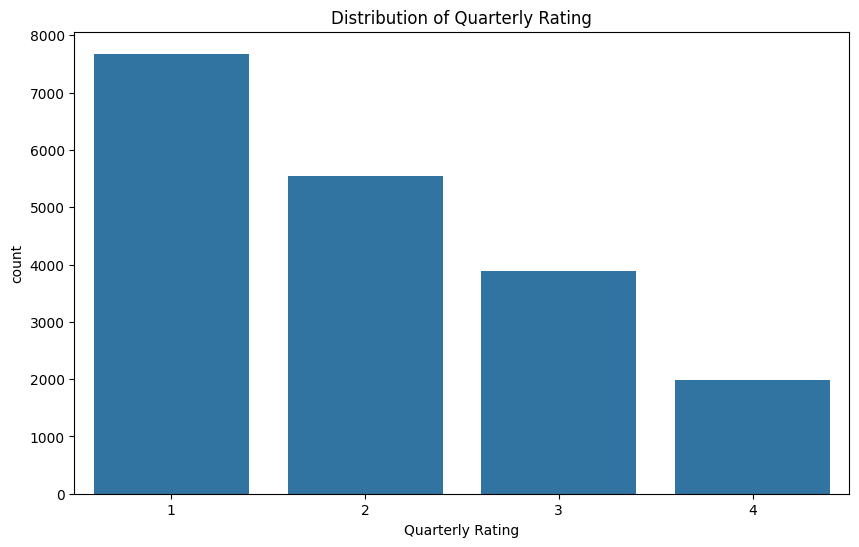

In [19]:
# Count plot for Quarterly Rating
plt.figure(figsize=(10, 6))
sns.countplot(x='Quarterly Rating', data=df)
plt.title('Distribution of Quarterly Rating')
plt.show()

#### Observations 
**Quarterly Rating:**
* 1: 7,679 drivers
* 2: 5,553 drivers
* 3: 3,895 drivers
* 4: 1,977 drivers
  

1. The majority of drivers have lower ratings(1 and 2). 76% of drivers fall within ratings 1 and 2.
2. The smaller group of drivers rated 3 or higher (around 30%) might indicate either stricter rating standards or a large number of under-performing drivers.

### Bi-variate Analysis

1. Correlation Heatmap

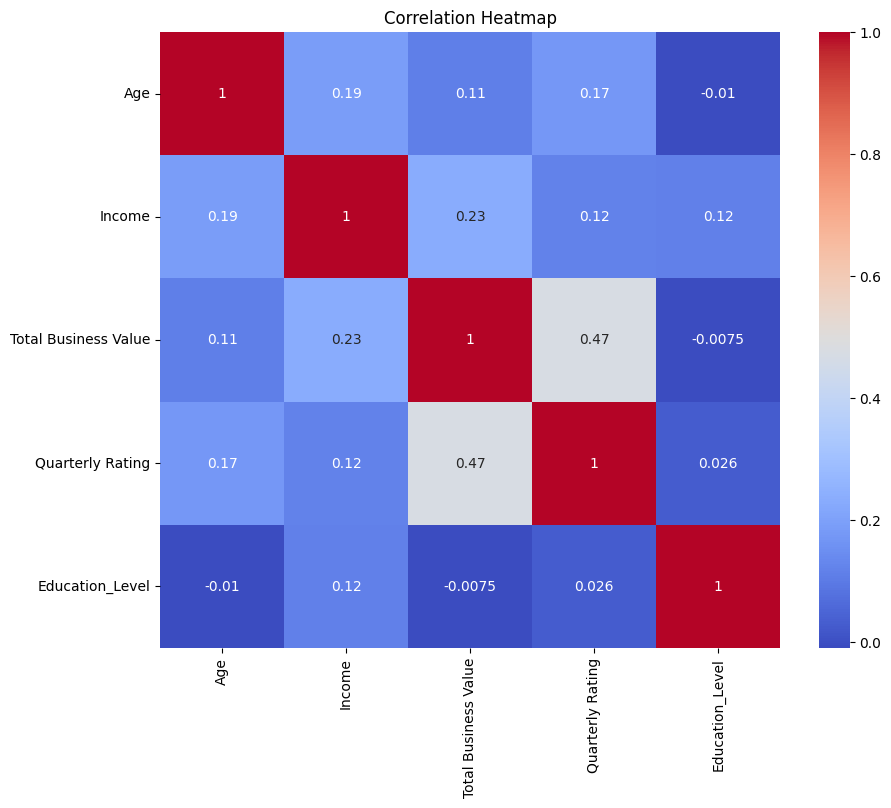

In [22]:
# correlation matrix for continuous variables
plt.figure(figsize=(10, 8))
sns.heatmap(df[['Age', 'Income', 'Total Business Value', 'Quarterly Rating', 'Education_Level']].corr(), annot=True,cmap='coolwarm' )
plt.title('Correlation Heatmap')
plt.show()

#### Observations Breakdown:
1. **Total Business Value vs. Quarterly Rating(0.47 correlation):**
   * A strong positive   

2. Box Plot: Income vs Education Level

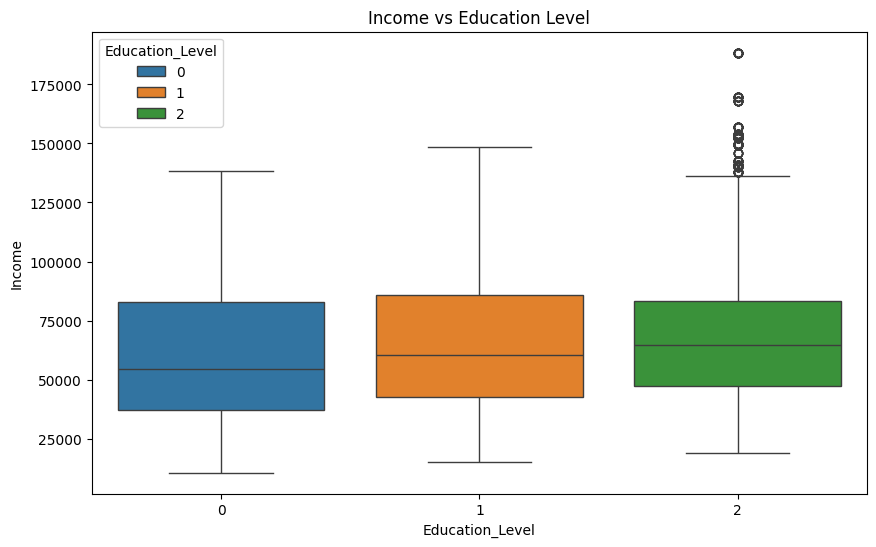

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education_Level', y='Income', data=df, hue='Education_Level')
plt.title('Income vs Education Level')
plt.show()

3. Scatter Plot: Income vs Age

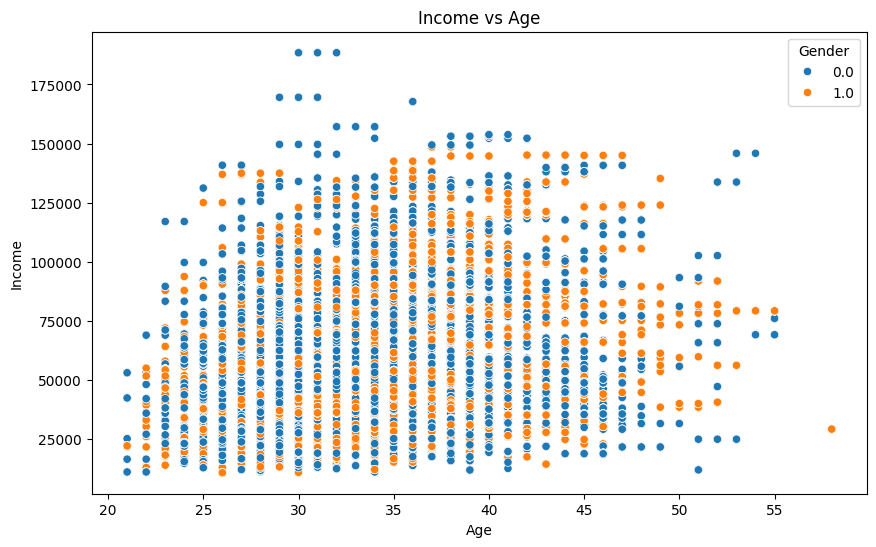

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Income', data=df, hue='Gender')
plt.title('Income vs Age')
plt.show()

4. Box Plot: Total Business Value vs Quarterly Rating
   

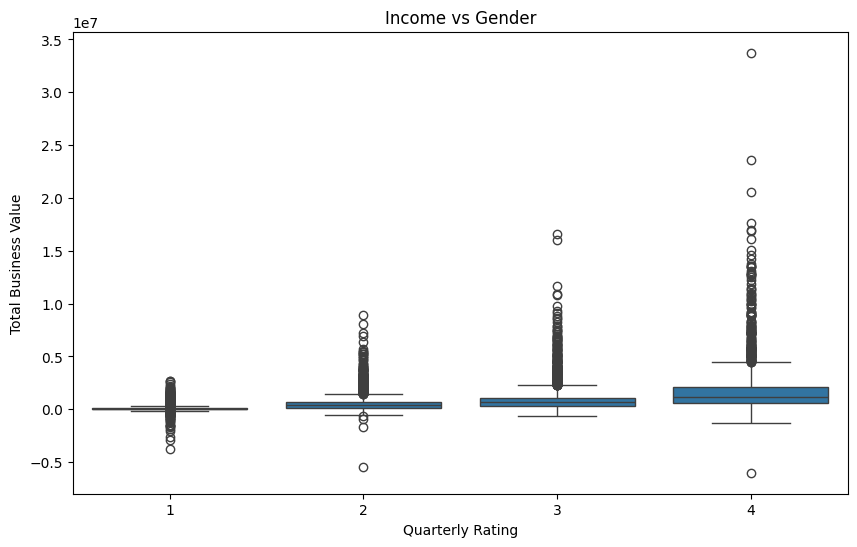

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Quarterly Rating', y='Total Business Value', data=df)
plt.title('Income vs Gender')
plt.show()

5. Box Plot: Income vs Gender

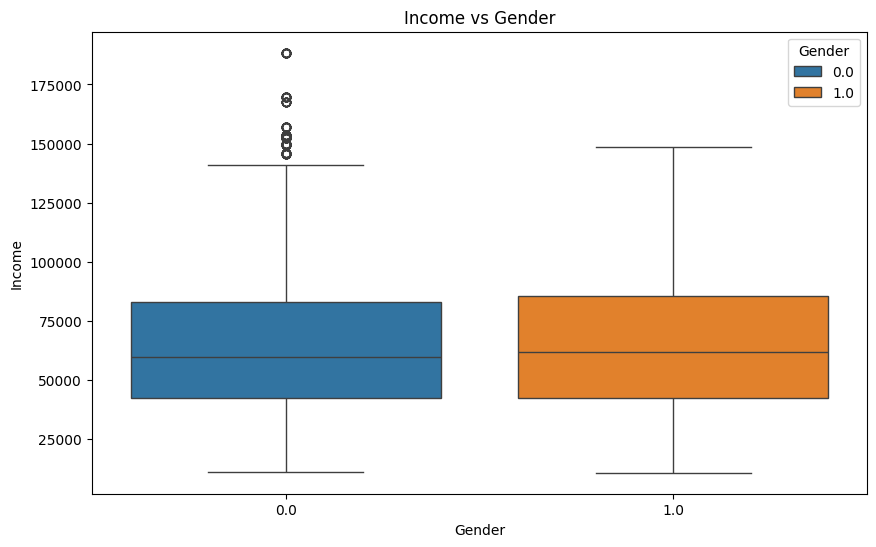

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Income', data=df, hue='Gender')
plt.title('Income vs Gender')
plt.show()